# An initial analysis into the spread of Covid-19

## Introduction

With the ongoing Covid-19 pandemic it is critical that we determine what factors accelerate and decelerate the spread of the disease in the initial weeks.  This notebook is a preliminary look into the data to help us understand these factors.  Because this disease has such a long latency period, it is severly contagious well before the patient becomes symptomatic, leading to a scenario where people are not able to receive care because of how flooded the medical care system is.  The goal of flattening the curve is to maximize the number of patients able to get treatment throughout the duration of the pandemic.
<img src="Data\flattencurve.png">

Our goal is to test and validate the following statistical hypothesis:

$$H_0: \tilde{x}_{CaseRateLo} - \tilde{x}_{CaseRateHi} = 0$$

## Additional References

https://plot.ly/python-api-reference/generated/plotly.express.scatter_geo.html

https://plot.ly/python/scatter-plots-on-maps/

https://blog.chezo.uno/tabula-py-extract-table-from-pdf-into-python-dataframe-6c7acfa5f302

https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/

https://www.cdc.gov/sars/index.html

https://www.cdc.gov/coronavirus/mers/index.html

https://www.worldweatheronline.com/developer/api/docs/historical-weather-api.aspx

## Analysis

### Data Cleaning

#### Calling reference libraries and importing data [here](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.stats as st
import collections
import datetime as dt
import time
import numpy as np
import requests as rq

cvdtimecase = pd.read_csv('Data/time_series_covid_19_confirmed.csv')
cvdtimedead = pd.read_csv('Data/time_series_covid_19_deaths.csv')
cvdtimewell = pd.read_csv('Data/time_series_covid_19_recovered.csv')

display(
    cvdtimecase.head(),
    cvdtimedead.head(),
    cvdtimewell.head()
)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,6,6,6,6,10,10,15,16,19,22
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,...,31,31,31,31,31,33,34,34,35,35
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,...,43,46,76,76,76,101,118,118,118,118
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,78,78,78,78,78,78,96,96,97,105
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,22,22,23,24,24,24,26,26,26,35


In [2]:
newdf = pd.concat(
    [cvdtimecase, cvdtimedead, cvdtimewell],
    keys=['cases', 'deaths', 'recoveries'],
    names=['count_type', 'locationID']
).reset_index(level=['count_type', 'locationID']).sort_values(['Country/Region', 'Province/State', 'count_type']).reset_index(drop=True)
colreorder = ['locationID', 'Country/Region', 'Province/State', 'Lat', 'Long', 'count_type']
newdf = newdf[colreorder + [col for col in newdf.columns if col not in colreorder]]
newdf.head()

,locationID,Country/Region,Province/State,Lat,Long,count_type,1/22/20,1/23/20,1/24/20,1/25/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,26,Afghanistan,NaN,33.0000,65.0000,cases,0,0,0,0,...,1,1,1,4,4,5,7,7,7,11
1,26,Afghanistan,NaN,33.0000,65.0000,deaths,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26,Afghanistan,NaN,33.0000,65.0000,recoveries,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,97,Albania,NaN,41.1533,20.1683,cases,0,0,0,0,...,0,0,0,0,2,10,12,23,33,38
4,97,Albania,NaN,41.1533,20.1683,deaths,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1


There are a significant number of null values in the 'Province/State' column, so let's fill that with a string so when we need to drop nulls later, it won't affect our results

In [3]:
newdf = newdf.fillna('N/A')
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 59 columns):
locationID        1326 non-null int64
Country/Region    1326 non-null object
Province/State    1326 non-null object
Lat               1326 non-null float64
Long              1326 non-null float64
count_type        1326 non-null object
1/22/20           1326 non-null int64
1/23/20           1326 non-null int64
1/24/20           1326 non-null int64
1/25/20           1326 non-null int64
1/26/20           1326 non-null int64
1/27/20           1326 non-null int64
1/28/20           1326 non-null int64
1/29/20           1326 non-null int64
1/30/20           1326 non-null int64
1/31/20           1326 non-null int64
2/1/20            1326 non-null int64
2/2/20            1326 non-null int64
2/3/20            1326 non-null int64
2/4/20            1326 non-null int64
2/5/20            1326 non-null int64
2/6/20            1326 non-null int64
2/7/20            1326 non-null int64
2/8/20      

Data looks good now, will probably need to pivot to get it in a usable and plottable format.  Will also break out the location details into a separate table and just keep locationID, count type, and data in the main DF

In [4]:
loccolumns = ['locationID', 'Country/Region', 'Province/State', 'Lat', 'Long']
locationref = newdf[loccolumns].drop_duplicates().reset_index(drop=True)
display(locationref.info(), [item for item, count in collections.Counter(locationref['locationID']).items() if count > 1])
#locationIDs [416, 417, 418, 415] are duplicated so, now I can go back to the main DF and figure out what's going on

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 5 columns):
locationID        446 non-null int64
Country/Region    446 non-null object
Province/State    446 non-null object
Lat               446 non-null float64
Long              446 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 17.5+ KB


None

[416, 417, 418, 415]

locationref had 446 rows when the combined tables each had 442 so there's a mismatch how I'm using the locationID

In [5]:
newdf[(415 <= newdf['locationID']) & (418 >= newdf['locationID'])]

,locationID,Country/Region,Province/State,Lat,Long,count_type,1/22/20,1/23/20,1/24/20,1/25/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
21,416,Aruba,N/A,12.5211,-69.9683,cases,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
22,416,Aruba,N/A,12.5211,-69.9683,deaths,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,417,Aruba,N/A,12.5211,-69.9683,recoveries,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,417,Canada,Grand Princess,37.6489,-122.6655,cases,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
103,417,Canada,Grand Princess,37.6489,-122.6655,deaths,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,418,Canada,Grand Princess,37.6489,-122.6655,recoveries,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,415,Guinea,N/A,9.9456,-9.6966,cases,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
325,415,Guinea,N/A,9.9456,-9.6966,deaths,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326,416,Guinea,N/A,9.9456,-9.6966,recoveries,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
378,418,Kenya,N/A,-0.0236,37.9062,cases,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


It appears that the recoveries table has the mismatches so let's go back and fix it
{415: Guinea, 416: Aruba, 417: Canada/Grand Princess, 418: Kenya}

In [6]:
newdf.at[23, 'locationID'] = 416
newdf.at[104, 'locationID'] = 417
newdf.at[326, 'locationID'] = 415
newdf.at[380, 'locationID'] = 418
newdf[(415 <= newdf['locationID']) & (418 >= newdf['locationID'])]

,locationID,Country/Region,Province/State,Lat,Long,count_type,1/22/20,1/23/20,1/24/20,1/25/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
21,416,Aruba,N/A,12.5211,-69.9683,cases,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
22,416,Aruba,N/A,12.5211,-69.9683,deaths,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,416,Aruba,N/A,12.5211,-69.9683,recoveries,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,417,Canada,Grand Princess,37.6489,-122.6655,cases,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
103,417,Canada,Grand Princess,37.6489,-122.6655,deaths,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,417,Canada,Grand Princess,37.6489,-122.6655,recoveries,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,415,Guinea,N/A,9.9456,-9.6966,cases,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
325,415,Guinea,N/A,9.9456,-9.6966,deaths,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326,415,Guinea,N/A,9.9456,-9.6966,recoveries,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
378,418,Kenya,N/A,-0.0236,37.9062,cases,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


it looks like we got rid of the mismatches, so now when we pull the location table, we should have the correct number of values, all consistent.  There's a lot of repeated data for the individual locations.  Now that locationID is a unique identifier, we don't need the rest of the data with our primary dataset

In [7]:
locationref = newdf[loccolumns].drop_duplicates().reset_index(drop=True)
loccolumns.remove('locationID')
newdf = newdf.drop(columns=loccolumns)
display(locationref.info(), newdf.head(), locationref)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 5 columns):
locationID        442 non-null int64
Country/Region    442 non-null object
Province/State    442 non-null object
Lat               442 non-null float64
Long              442 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 17.4+ KB


None

,locationID,count_type,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,26,cases,0,0,0,0,0,0,0,0,...,1,1,1,4,4,5,7,7,7,11
1,26,deaths,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26,recoveries,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,97,cases,0,0,0,0,0,0,0,0,...,0,0,0,0,2,10,12,23,33,38
4,97,deaths,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1


,locationID,Country/Region,Province/State,Lat,Long
0,26,Afghanistan,N/A,33.0000,65.0000
1,97,Albania,N/A,41.1533,20.1683
2,29,Algeria,N/A,28.0339,1.6596
3,61,Andorra,N/A,42.5063,1.5218
4,419,Antigua and Barbuda,N/A,17.0608,-61.7964
...,...,...,...,...,...
437,406,United Kingdom,United Kingdom,55.3781,-3.4360
438,422,Uruguay,N/A,-32.5228,-55.7658
439,429,Venezuela,N/A,6.4238,-66.5897
440,193,Vietnam,N/A,16.0000,108.0000


One category we want to create is for our Latitude bins to see if there's any correlation that we can use for A/B testing

In [8]:
bins = list(range(-45, 65, 5))
binlabel = list(range(1, len(bins)))
locationref['Latbins'] = pd.cut(locationref['Lat'], bins, labels=binlabel)
locationref

,locationID,Country/Region,Province/State,Lat,Long,Latbins
0,26,Afghanistan,N/A,33.0000,65.0000,16
1,97,Albania,N/A,41.1533,20.1683,18
2,29,Algeria,N/A,28.0339,1.6596,15
3,61,Andorra,N/A,42.5063,1.5218,18
4,419,Antigua and Barbuda,N/A,17.0608,-61.7964,13
...,...,...,...,...,...,...
437,406,United Kingdom,United Kingdom,55.3781,-3.4360,21
438,422,Uruguay,N/A,-32.5228,-55.7658,3
439,429,Venezuela,N/A,6.4238,-66.5897,11
440,193,Vietnam,N/A,16.0000,108.0000,13


In order for any plotting and general data analysis, we need to convert our wide-shape data into a long format to get each series easier

In [9]:
tallnewdf = pd.melt(newdf, id_vars=['locationID', 'count_type'], value_name='count', var_name='Date')
tallnewdf['Date'] = pd.to_datetime(tallnewdf['Date'])
tallnewdf.head()

,locationID,count_type,Date,count
0,26,cases,2020-01-22,0
1,26,deaths,2020-01-22,0
2,26,recoveries,2020-01-22,0
3,97,cases,2020-01-22,0
4,97,deaths,2020-01-22,0


In [10]:
display(
    tallnewdf.info(),
    locationref.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70278 entries, 0 to 70277
Data columns (total 4 columns):
locationID    70278 non-null int64
count_type    70278 non-null object
Date          70278 non-null datetime64[ns]
count         70278 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 6 columns):
locationID        442 non-null int64
Country/Region    442 non-null object
Province/State    442 non-null object
Lat               442 non-null float64
Long              442 non-null float64
Latbins           436 non-null category
dtypes: category(1), float64(2), int64(1), object(2)
memory usage: 18.6+ KB


None

None

The data also includes many areas where there haven't been any reported cases yet, so we will drop all such locations from our data

In [11]:
for locations in locationref['locationID']:
    datacheck = tallnewdf[
        (tallnewdf['locationID'] == locations) &
        (tallnewdf['count_type'] == 'cases')
    ]
    if datacheck['count'].sum() < 1:
        tallnewdf = tallnewdf[tallnewdf['locationID'] != locations]
        locationref = locationref[locationref['locationID'] != locations]

Text(0.5, 1.0, 'Time Series of Covid-19 in\nHubei, China')

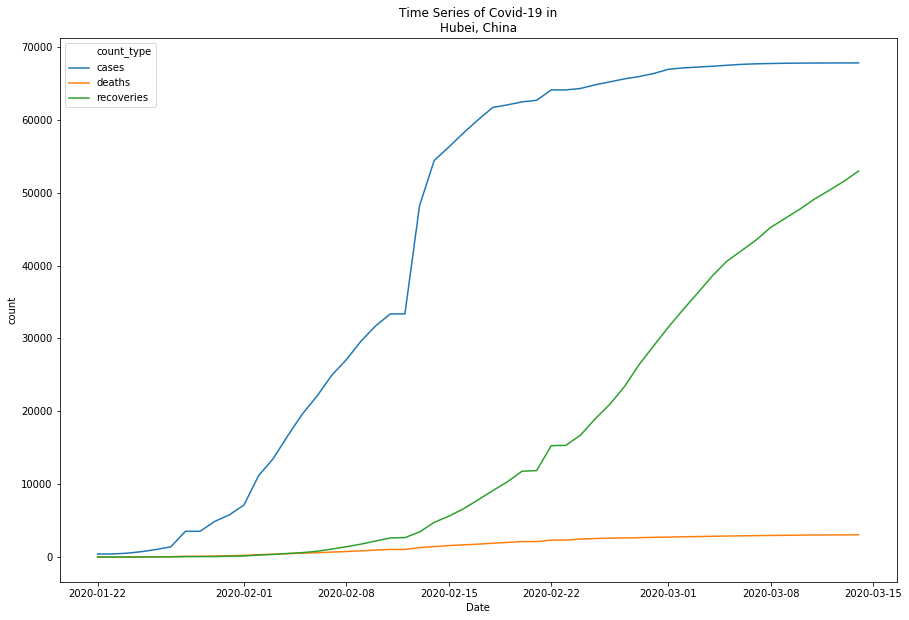

In [13]:
plt.figure(figsize=[15, 10])
sn.lineplot(x='Date', y='count', hue='count_type', data=tallnewdf[tallnewdf['locationID'] == 156])
plt.title('Time Series of Covid-19 in\n{}, {}'.format(
    locationref[locationref['locationID'] == 156].iat[0,2], 
    locationref[locationref['locationID'] == 156].iat[0,1]))

### Data Analysis

The next step will be to determine and record when the first case of Covid-19 occurred for each location and each concurrent case count on a weekly basis.

This gen_week_loop() function is designed to place date values for each consecutive week once the first case has been recorded in the code below.

I am making a decision here to also limit what data I will display by only calling the gen_week_loop() function on locations where I have at least 6 weeks worth of data

In [14]:
def gen_week_loop(n, l):
    for i in range(n):
        clmnnamestr = 'Week_' + str(i + 1)
        tempdf = locationref[locationref['locationID'] == l]
        fc = tempdf['first_case']
        newdate = fc + dt.timedelta(days=(7 * (i + 1)))
        locationref.at[tempdf.index, clmnnamestr] = newdate


for locations in locationref['locationID']:
    templocdf = tallnewdf[
        (tallnewdf['locationID'] == locations) & 
        (tallnewdf['count_type'] == 'cases') & 
        (tallnewdf['count'] > 0)]
    firstrecord = templocdf['Date'].min()
    lastrecord = templocdf['Date'].max()
    locationref.at[locationref[locationref['locationID'] == locations].index, 'first_case'] = firstrecord.date()
    datediff = (lastrecord.date() - firstrecord.date()).days // 7
    if datediff > 5:
        gen_week_loop(datediff, locations)
display(
    locationref.info(),
    locationref.describe(),
    locationref
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 440
Data columns (total 14 columns):
locationID        351 non-null int64
Country/Region    351 non-null object
Province/State    351 non-null object
Lat               351 non-null float64
Long              351 non-null float64
Latbins           345 non-null category
first_case        351 non-null object
Week_1            65 non-null object
Week_2            65 non-null object
Week_3            65 non-null object
Week_4            65 non-null object
Week_5            65 non-null object
Week_6            65 non-null object
Week_7            41 non-null object
dtypes: category(1), float64(2), int64(1), object(10)
memory usage: 49.5+ KB


None

,locationID,Lat,Long
count,351.000000,351.000000,351.000000
mean,196.239316,30.745175,-24.297943
std,127.253537,19.967390,84.248909
min,0.000000,-41.454500,-157.858400
25%,87.500000,24.487000,-88.341850
50%,176.000000,36.576100,-66.590100
75%,301.500000,42.313600,32.447900
max,440.000000,64.963100,174.886000


,locationID,Country/Region,Province/State,Lat,Long,Latbins,first_case,Week_1,Week_2,Week_3,Week_4,Week_5,Week_6,Week_7
0,26,Afghanistan,N/A,33.0000,65.0000,16,2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,97,Albania,N/A,41.1533,20.1683,18,2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29,Algeria,N/A,28.0339,1.6596,15,2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,61,Andorra,N/A,42.5063,1.5218,18,2020-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,419,Antigua and Barbuda,N/A,17.0608,-61.7964,13,2020-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,211,United Kingdom,Gibraltar,36.1408,-5.3536,17,2020-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
437,406,United Kingdom,United Kingdom,55.3781,-3.4360,21,2020-01-31,2020-02-07,2020-02-14,2020-02-21,2020-02-28,2020-03-06,2020-03-13,NaN
438,422,Uruguay,N/A,-32.5228,-55.7658,3,2020-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
439,429,Venezuela,N/A,6.4238,-66.5897,11,2020-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For the same reasons listed above, we will melt our Dataframe once again to get the data into a long format

In [15]:
locationref = pd.melt(
    locationref, 
    id_vars=['locationID', 'Country/Region', 'Province/State', 'Lat', 'Long', 'Latbins'], 
    value_name='Date', 
    var_name='Week'
)
display(
    locationref.head(),
    locationref[locationref['locationID'] == 406]
)

,locationID,Country/Region,Province/State,Lat,Long,Latbins,Week,Date
0,26,Afghanistan,N/A,33.0000,65.0000,16,first_case,2020-02-24
1,97,Albania,N/A,41.1533,20.1683,18,first_case,2020-03-09
2,29,Algeria,N/A,28.0339,1.6596,15,first_case,2020-02-25
3,61,Andorra,N/A,42.5063,1.5218,18,first_case,2020-03-02
4,419,Antigua and Barbuda,N/A,17.0608,-61.7964,13,first_case,2020-03-13


,locationID,Country/Region,Province/State,Lat,Long,Latbins,Week,Date
347,406,United Kingdom,United Kingdom,55.3781,-3.436,21,first_case,2020-01-31
698,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_1,2020-02-07
1049,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_2,2020-02-14
1400,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_3,2020-02-21
1751,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_4,2020-02-28
2102,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_5,2020-03-06
2453,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_6,2020-03-13
2804,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_7,NaN


In [16]:
locationref = locationref.dropna().reset_index(drop=True)
display(
    locationref.head(),
    locationref[locationref['locationID'] == 406]
)

,locationID,Country/Region,Province/State,Lat,Long,Latbins,Week,Date
0,26,Afghanistan,N/A,33.0000,65.0000,16,first_case,2020-02-24
1,97,Albania,N/A,41.1533,20.1683,18,first_case,2020-03-09
2,29,Algeria,N/A,28.0339,1.6596,15,first_case,2020-02-25
3,61,Andorra,N/A,42.5063,1.5218,18,first_case,2020-03-02
4,419,Antigua and Barbuda,N/A,17.0608,-61.7964,13,first_case,2020-03-13


,locationID,Country/Region,Province/State,Lat,Long,Latbins,Week,Date
341,406,United Kingdom,United Kingdom,55.3781,-3.436,21,first_case,2020-01-31
406,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_1,2020-02-07
469,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_2,2020-02-14
532,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_3,2020-02-21
595,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_4,2020-02-28
658,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_5,2020-03-06
721,406,United Kingdom,United Kingdom,55.3781,-3.436,21,Week_6,2020-03-13


As defined in my research proposal, my main goal is to determine correlations and factors that impact the rate of change in the number of cases, deaths, and recoveries

In [19]:
def IROC_data(longweekdata):
    for locations in longweekdata['locationID']:
        templocdata = longweekdata[longweekdata['locationID'] == locations].sort_values('Date')
        nweeks = templocdata['locationID'].count() - 1
        for i in range(nweeks):
            caseslindata = tallnewdf[
                (tallnewdf['locationID'] == locations) & 
                (tallnewdf['count_type'] == 'cases') & 
                (tallnewdf['Date'] <= pd.Timestamp(templocdata.iat[i+1,7])) & 
                (tallnewdf['Date'] >= pd.Timestamp(templocdata.iat[i,7]))].reset_index(drop=True)
            longweekdata.at[templocdata.index[i + 1], 'IROC_cases'], _, _, _, _ = st.linregress(caseslindata.index, caseslindata['count'])
            
            deathslindata = tallnewdf[
                (tallnewdf['locationID'] == locations) & 
                (tallnewdf['count_type'] == 'deaths') & 
                (tallnewdf['Date'] <= pd.Timestamp(templocdata.iat[i+1,7])) & 
                (tallnewdf['Date'] >= pd.Timestamp(templocdata.iat[i,7]))].reset_index(drop=True)
            longweekdata.at[templocdata.index[i + 1], 'IROC_deaths'], _, _, _, _ = st.linregress(deathslindata.index, deathslindata['count'])
            
            recoverlindata = tallnewdf[
                (tallnewdf['locationID'] == locations) & 
                (tallnewdf['count_type'] == 'recoveries') & 
                (tallnewdf['Date'] <= pd.Timestamp(templocdata.iat[i+1,7])) & 
                (tallnewdf['Date'] >= pd.Timestamp(templocdata.iat[i,7]))].reset_index(drop=True)
            longweekdata.at[templocdata.index[i + 1], 'IROC_recoveries'], _, _, _, _ = st.linregress(recoverlindata.index, recoverlindata['count'])
    return longweekdata

postdata = IROC_data(locationref)
display(postdata)

,locationID,Country/Region,Province/State,Lat,Long,Latbins,Week,Date,IROC_cases,IROC_deaths,IROC_recoveries
0,26,Afghanistan,N/A,33.0000,65.0000,16,first_case,2020-02-24,NaN,NaN,NaN
1,97,Albania,N/A,41.1533,20.1683,18,first_case,2020-03-09,NaN,NaN,NaN
2,29,Algeria,N/A,28.0339,1.6596,15,first_case,2020-02-25,NaN,NaN,NaN
3,61,Andorra,N/A,42.5063,1.5218,18,first_case,2020-03-02,NaN,NaN,NaN
4,419,Antigua and Barbuda,N/A,17.0608,-61.7964,13,first_case,2020-03-13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
759,3,Nepal,N/A,28.1667,84.2500,15,Week_7,2020-03-14,0.000000,0.0,0.000000
760,2,Singapore,N/A,1.2833,103.8333,10,Week_7,2020-03-12,8.726190,0.0,2.571429
761,192,Taiwan*,N/A,23.7000,121.0000,14,Week_7,2020-03-11,0.678571,0.0,0.833333
762,0,Thailand,N/A,15.0000,101.0000,12,Week_7,2020-03-11,1.761905,0.0,0.369048


we want to plot our distribution figures for each week so let's use this list to make it easier

In [20]:
weektry = list(postdata['Week'].unique())
weektry.remove('first_case')

we also need to determine what our significant value to split the data will be.  I started with a value of 1 since values less than one signify that the case rate is decelerating. After seeing how the samples were split, with the significant majority of locations having rates < 1, I decided to go by the 50% value for my case rate.

In the following code we will plot the boxplots for the recovery rate split into these two significant categories and performing the kruskal wallis test to determine whether the median recovery rate is significantly different on this parameter, with a significance value for alpha = 0.05

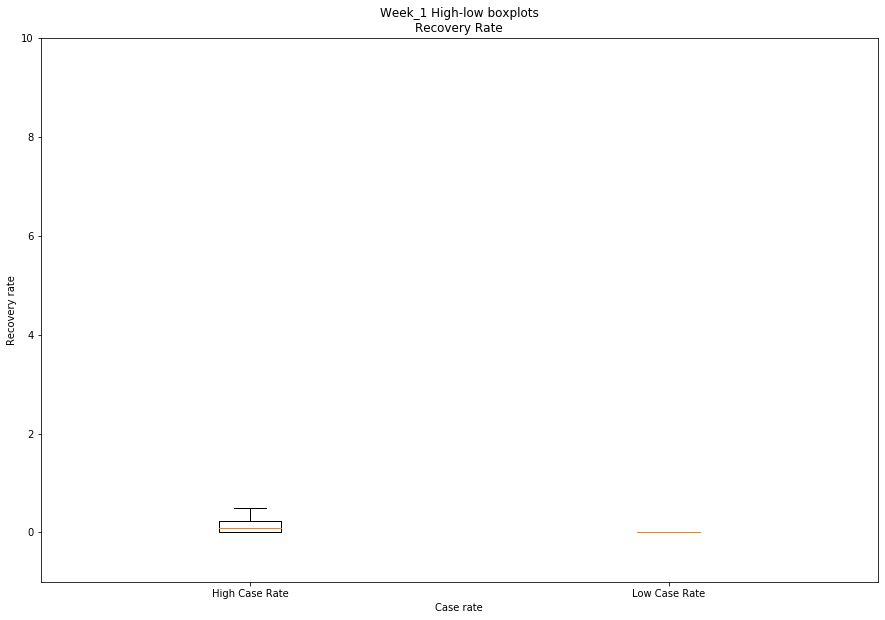

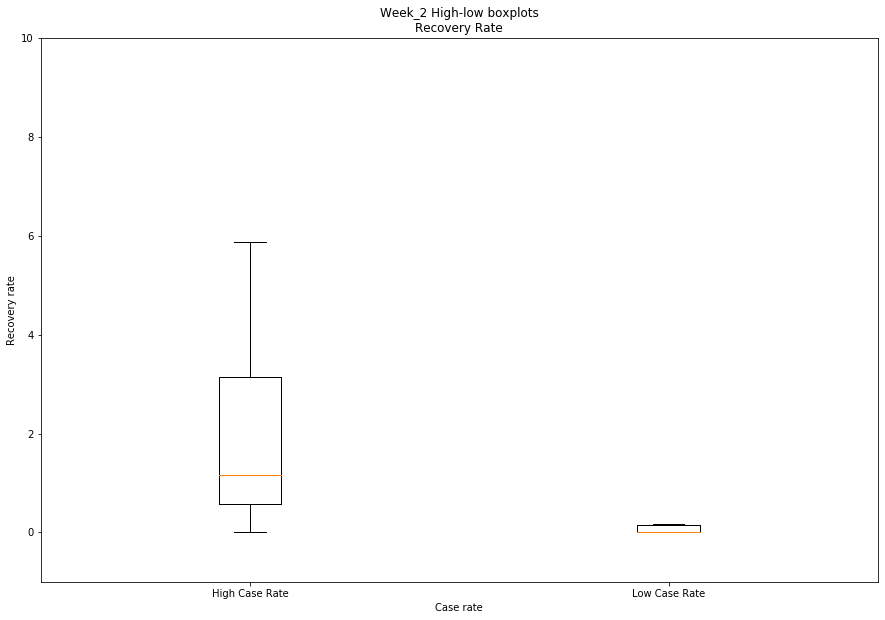

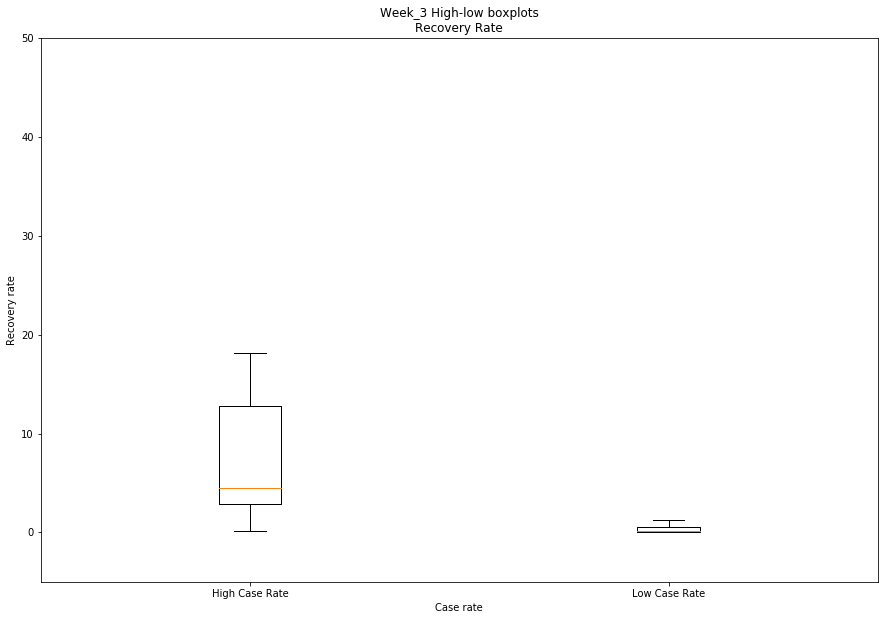

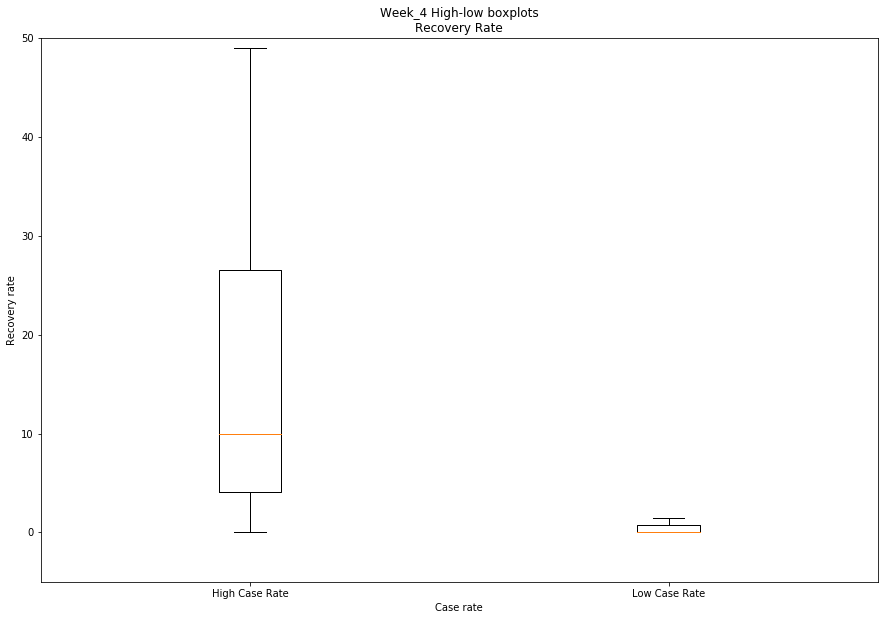

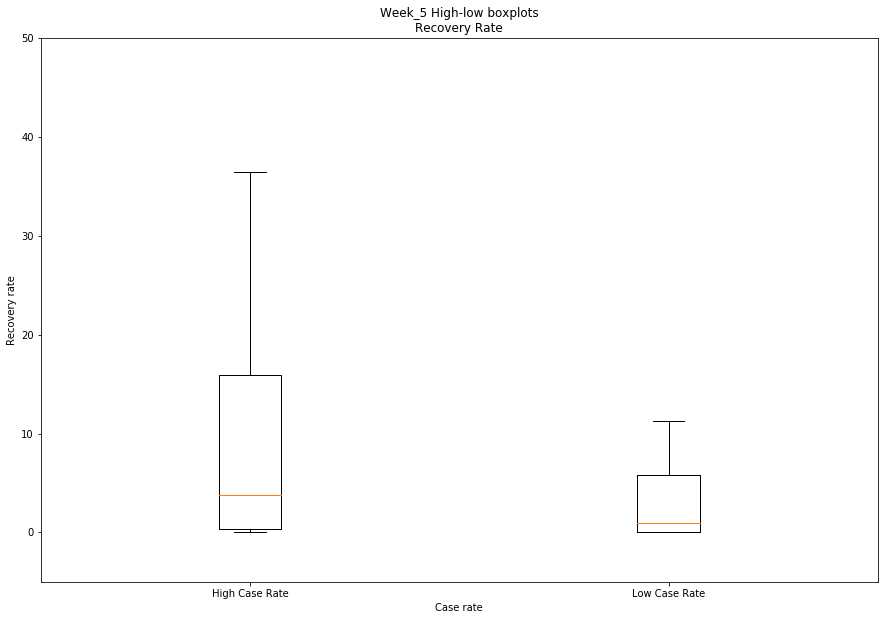

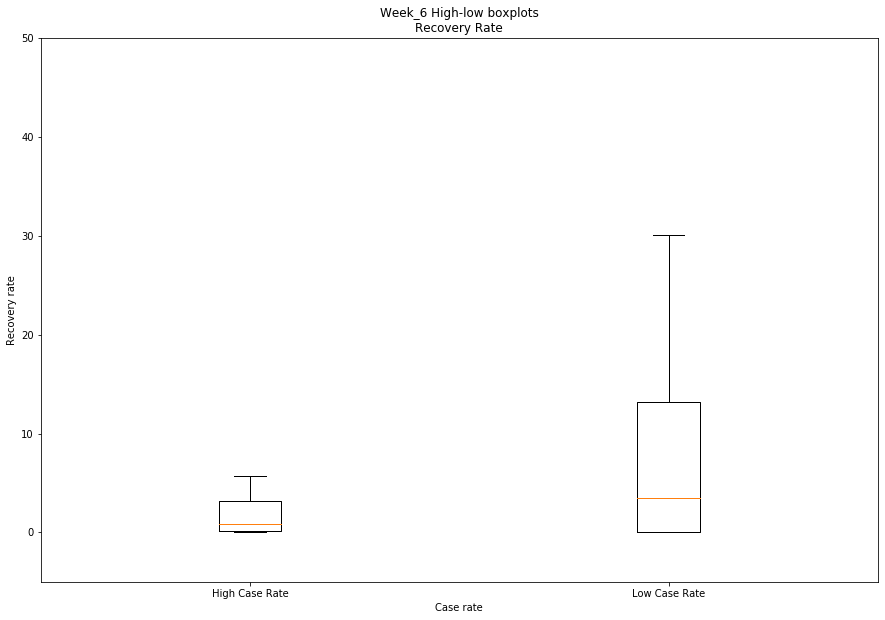

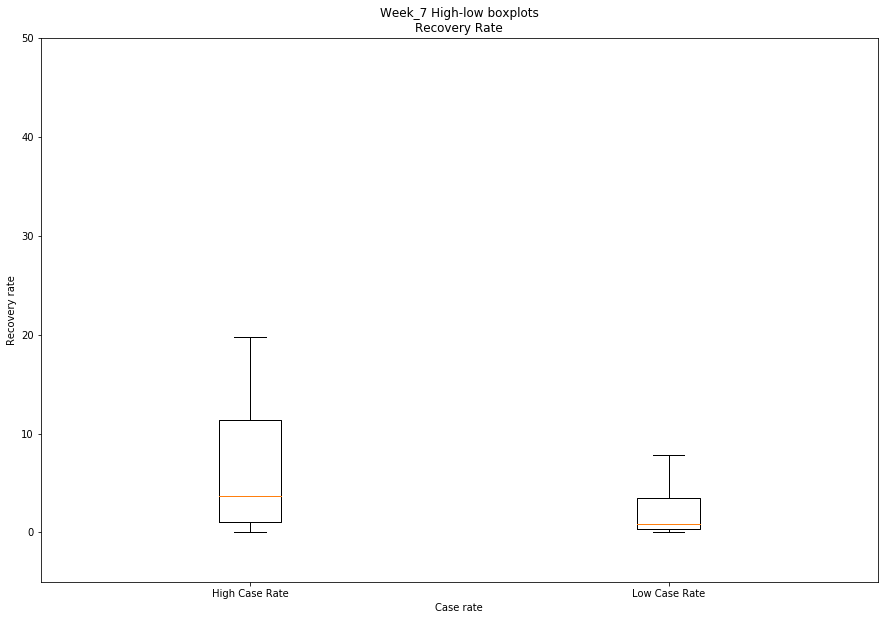

,K_values,p_values,psig
Week_1,15.989537,6.369351e-05,True
Week_2,36.171767,1.806692e-09,True
Week_3,38.741619,4.837830e-10,True
Week_4,34.442874,4.389469e-09,True
Week_5,3.103047,7.814590e-02,False
Week_6,0.698105,4.034212e-01,False
Week_7,4.545701,3.300151e-02,True


In [39]:
Ks = []
ps = []
testingvar = 'IROC_recoveries'
for weeks in weektry:
    halfcases = postdata[postdata['Week'] == weeks]['IROC_cases'].describe(include='all').loc['50%']
    plt.figure(figsize=[15, 10])
    plot1 = plt.boxplot(
        [
            postdata[
                (postdata['Week'] == weeks) &
                (postdata['IROC_cases'] > halfcases)
            ][testingvar],
            postdata[
                (postdata['Week'] == weeks) &
                (postdata['IROC_cases'] <= halfcases)
            ][testingvar]
        ],
        showfliers=False,
        labels=['High Case Rate', 'Low Case Rate']
    )
    plt.title('{} High-low boxplots\nRecovery Rate'.format(weeks))
    plt.xlabel('Case rate')
    plt.ylabel('Recovery rate')
    if weeks in ['Week_1', 'Week_2']:
        plt.ylim(-1, 10)
    else:
        plt.ylim(-5, 50)
    plt.show()
    K, p = st.kruskal(
        (postdata[
            (postdata['Week'] == weeks) &
            (postdata['IROC_cases'] > halfcases)
        ][testingvar]),
        (postdata[
            (postdata['Week'] == weeks) &
            (postdata['IROC_cases'] <= halfcases)
        ][testingvar])
    )
    Ks.append(K)
    ps.append(p)
datadict = {'K_values': Ks,'p_values': ps}
kruskalresults = pd.DataFrame(data=datadict, index=weektry)
kruskalresults['psig'] = kruskalresults['p_values'] <= 0.05
kruskalresults

As we figured, the median difference is significiant and we reject the null hypothesis.  Week 7 seems to be an oddity though the p value is still within an explainable difference and many factors can affect this.

## Conclusion

Our medians converge as the weeks progress and with the results from the table above, we can say that we reject the null hypothesis for the data from Week 1-4:

$$H_0: \tilde{x}_{CaseRateLo} - \tilde{x}_{CaseRateHi} = 0$$

In weeks 5-6 we can see that we will fail to reject the null hypothesis.  This tells us that the medians of the two groups where we split the data are converging.

Week 7 stands out since we again reject the null hypothesis.  Why did the trent falter?  Well we can't really say to be sure, what we **_CAN_** note however is the sample size is significantly smaller for our Week-7 data.  Perhaps, as data from more countries extends into Week-7 we'll see a change in the data to support our claim that the medians converge after 4 weeks.  However the opposite is also possible, Week-7 and all following weeks diverge again.  Perhaps, our initial analysis of median convergance is false.  

## Further Analysis

Now that we have determined that the medians converge, let's look at the factors that might impact the variance in recovery rates within the first four weeks of the disease entering a geographical area.

What can we look at?
* Geographical location
  * Correlation to Cases/Deaths/Recoveries
* Weather/Climate
  * Max, Min, Mean Temperature
  * Temperature variance
  * Biome
  * Humidity
  * Precipitation

In [ ]:
plt.figure(figsize=[15, 10])
sn.lineplot(x='Lat', y='IROC_cases', data=postdata, label='Cases')
plt.xlabel('Latitude')
plt.ylabel('Rate of Change')
plt.title('Rate of Change in the Number of Recorded Cases\nDistributed over Latitude')
plt.legend()

In [ ]:
plt.figure(figsize=[15, 10])
sn.lineplot(x='Lat', y='IROC_deaths', data=postdata, label='Deaths')
plt.xlabel('Latitude')
plt.legend()

In [ ]:
plt.figure(figsize=[15, 10])
sn.lineplot(x='Lat', y='IROC_recoveries', data=postdata, label='Recoveries')
plt.xlabel('Latitude')
plt.legend()

In [ ]:
plt.figure(figsize=[15, 10])
postdata['Latbins'].hist()
plt.xlabel('Latitude Bins')
plt.ylabel('Count')
plt.title('Recorded cases based on location\nGrouped With Latitude Bins')
plt.show()

Because the contagion started in China with the vast majority of cases occurrring in that one region, the geographical data is heavily skewed to that results, so we can't really draw much in terms of correlation since the spread outside of china has mostly been through air travel and contact with persons that traveled to that region.

My attempts at working with weather data can be found in the graveyard as it was a dead end with the API I was using, and didn't want to rehash the whole thing.  

Next let's look at time series, and see if we can spot any good and bad trends with the countries that have been tracking the infection for 6-7 weeks.

In [ ]:
plotdata = postdata.dropna().reset_index(drop=True)
loclist = plotdata[plotdata['Week'].isin(['Week_6', 'Week_7'])]['locationID'].unique()
plotdata = plotdata[plotdata['locationID'].isin(loclist)]

for locations in plotdata['locationID'].unique():
    templocplotdata = plotdata[plotdata['locationID'] == locations]
    plt.figure(figsize=[10, 7])
    plt.scatter(x='Week', y='IROC_cases', data=templocplotdata, label='Cases', c='orange', marker='X')
    plt.scatter(x='Week', y='IROC_deaths', data=templocplotdata, label='Deaths', c='red', marker='s')
    plt.scatter(x='Week', y='IROC_recoveries', data=templocplotdata, label='Recoveries', c='blue', marker='^')
    plt.plot('Week', 'IROC_cases', data=templocplotdata, c='orange', label='_nolegend_')
    plt.plot('Week', 'IROC_deaths', data=templocplotdata, c='red', label='_nolegend_')
    plt.plot('Week', 'IROC_recoveries', data=templocplotdata, c='blue', label='_nolegend_')
    plt.title(
        'Instantaneous Rate of Change from Day-Zero\nLocation-ID: {}, {}, {}'.format(
            templocplotdata.iat[0,0],
            templocplotdata.iat[0,2],
            templocplotdata.iat[0,1]
        )
    )
    plt.ylabel('Rate of Change')
    plt.xlabel(
        'Day-Zero: {}'.format(
            str(
                postdata[
                    (postdata['locationID'] == locations) &
                    (postdata['Week'] == 'first_case')
                ].iat[0,7]
            )
        )
    )
    plt.legend()
    plt.show()